In [4]:
from ast import literal_eval
from tqdm import tqdm
import numpy as np
import pandas as pd
import pytz
import matplotlib.pyplot as plt
from matplotlib.dates import drange
from matplotlib import dates as mpl_dates
import matplotlib
import datetime

utc=pytz.UTC
notes = pd.read_csv('../data/notes-00000.tsv', sep='\t')
ratings = pd.read_csv('../data/ratings-00000.tsv', sep='\t')
hydrated_file = "../data/idtweetVALUES.jsonl"
json=pd.read_json(hydrated_file, lines=True)
claim_review_file = "../data/UpdatedClaimReview/2022_01_14/claim_reviews.json"
facts = pd.read_json(claim_review_file)

In [5]:
merge_corpus = pd.read_csv("../data/merged3_mturk.csv")

In [6]:
len(set(merge_corpus.tweetId))

2208

In [7]:
def f(x):
    try:
        if literal_eval(literal_eval(x)): return literal_eval(x)
    except: return x

In [8]:
merge_corpus['CR Fact']=merge_corpus['CR Fact'].apply(lambda x: f(x))

In [64]:

no_date=0
all_tweet_ts=[]
all_note_ts=[]
all_CR_ts=[]

for index,x in tqdm(merge_corpus.iloc[:].iterrows()):
    
    # Tweet TS
    tweet_ts = json[json.id==x.tweetId]['created_at'].squeeze().to_pydatetime()

    
    # BW timestamp
    notes_ts = notes.loc[(notes.tweetId==x.tweetId) & (notes.classification==x.classification)]
    note_ts=notes[notes.noteId==x.noteId].createdAtMillis.squeeze()
    note_ts = datetime.datetime.fromtimestamp(note_ts/1000)
    note_ts = utc.localize(note_ts)
    
    # CR timestamp
    CR_ts = facts[facts.apply(lambda y: True if y.claim_text == literal_eval(x['CR Fact']) else False,axis=1)]
    flattened_list=(CR_ts.reviews.apply(lambda x: [xx['date_published'] for xx in x]))
    flattened_list = [xx for x in flattened_list for xx in x]
    flattened_list = [x for x in flattened_list if x]
    if not flattened_list:
        no_date+=1
        CR_ts= None
        all_tweet_ts.append(tweet_ts)
        all_note_ts.append(note_ts)
        all_CR_ts.append(CR_ts)
    else:    
        flattened_list = [datetime.datetime.strptime(x,'%Y-%m-%d') for x in flattened_list]
        CR_ts = min(flattened_list)
        CR_ts= utc.localize(CR_ts)
        all_tweet_ts.append(tweet_ts)
        all_note_ts.append(note_ts)
        all_CR_ts.append(CR_ts)


3043it [2:42:34,  3.21s/it]


In [37]:
s=merge_corpus[merge_corpus.noteId==1380365994611335169]['CR Fact'].squeeze()

In [66]:
merge_corpus['Tweet_ts']=all_tweet_ts
merge_corpus['Note_ts']=all_note_ts
merge_corpus['CR_ts']=all_CR_ts

In [10]:
merge_corpus.to_csv('../data/merged3_with_time.csv',index=False)

In [44]:
merge_corpus=pd.read_csv('../data/merged3_with_time.csv')

In [68]:
#check that no tweet has note ts before tweet ts
merge_corpus[merge_corpus.apply(lambda x: True if x['Tweet_ts']>x['Note_ts'] else False,axis=1)]

,Tweet,credibility,tweetId,CR Fact,noteId,summary,classification,full_text,Tweet_ts,Note_ts,CR_ts


In [194]:
merge_corpus=merge_corpus.dropna()

# T  B  C

In [74]:
merge_corpus=merge_corpus.dropna()

In [71]:
#check that which tweet has note ts before CR ts
BW_before=merge_corpus[merge_corpus.apply(lambda x: True if x['CR_ts']>x['Note_ts'] else False,axis=1)]

In [75]:
BW_before.drop_duplicates(subset=['tweetId']).shape

(129, 11)

In [25]:
for index,row in BW_before.iterrows():
    print(f'Tweet: {row.full_text}')
    print()
    print(row.tweetId)
    print(f'CR Label: {row.credibility}')
    print()
    print(f'Note Label: {row.classification}')
    print()
    print(f'CR Fact: {row["CR Fact"]}')
    print()
    print(f'Note: {row.summary}')
    print()
    current_note_ts = notes[notes.noteId==row.noteId]['createdAtMillis'].squeeze()
    current_note_ts = utc.localize(datetime.datetime.fromtimestamp(current_note_ts/1000))
    print(f'Time Difference: {row["CR_ts"]-current_note_ts}')
    print()
    print("######################################################################################")

Tweet: HUGE DEVELOPMENT: Hand Recount Finds Dominion Voting Machines Shorted EVERY REPUBLICAN Candidate in Windham, New Hampshire, 300 Votes! https://t.co/eEpgTvkZp7

1359676873668714497
CR Label: uncertain

Note Label: MISINFORMED_OR_POTENTIALLY_MISLEADING

CR Fact: ['Windham, New Hampshire recount proves fraud by Dominion Voting Systems technology.']

Note: The author of the Tweet has indicated that all Republicans were shorted 300 votes in a NH county.  This is extremely misleading.  Only 4 candidates saw shortages that were corrected by a hand recount, it also did not lead to any changes to the election outcome.      https://patch.com/new-hampshire/windham/investigators-eye-voting-devices-cards-after-windham-recount

Time Difference: 2 days 01:09:55.037000

######################################################################################
Tweet: @RudyGiuliani I urge you to look at TOTAL deaths year by year for past ten years. 2020 is lower than 8 out of 10 previous years. Where

## Histogram Delay between Tweet

In [80]:
BW_before_dup=BW_before.sort_values(by=['full_text','Note_ts']).drop_duplicates(subset='full_text')

<AxesSubplot:xlabel='Hours from Tweet to Write Note'>

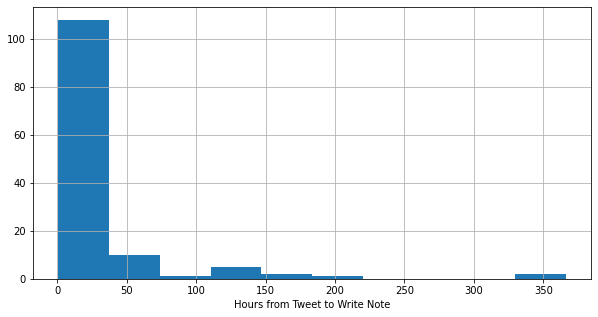

In [81]:
plt.figure(figsize=(10,5))
plt.xlabel('Hours from Tweet to Write Note')
(BW_before_dup['Note_ts']-BW_before_dup['Tweet_ts']).astype('timedelta64[h]').hist()


<AxesSubplot:xlabel='Hours from Tweet to get a CR'>

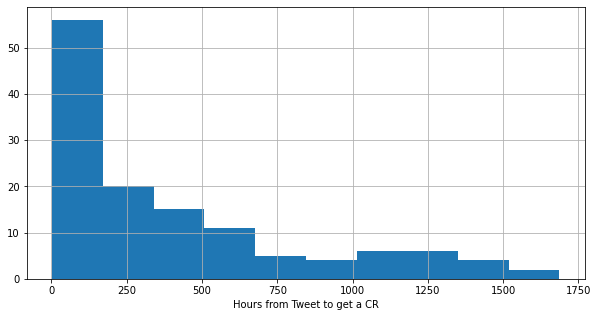

In [82]:
plt.figure(figsize=(10,5))
plt.xlabel('Hours from Tweet to get a CR')
(BW_before_dup['CR_ts']-BW_before_dup['Tweet_ts']).astype('timedelta64[h]').hist()


In [83]:
a=(BW_before_dup['Note_ts']-BW_before_dup['Tweet_ts']).astype('timedelta64[h]')
b=(BW_before_dup['CR_ts']-BW_before_dup['Tweet_ts']).astype('timedelta64[h]')

<AxesSubplot:xlabel='Ratio of Time by CR to time by BW'>

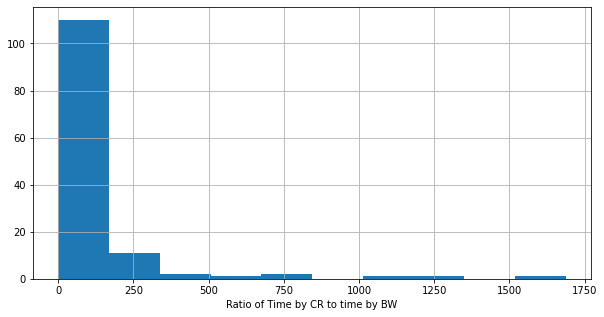

In [84]:
plt.figure(figsize=(10,5))
plt.xlabel('Ratio of Time by CR to time by BW')
(b/a).hist()

In [85]:
c=b/a

<AxesSubplot:xlabel='Ratio of Time by CR to time by BW for check-worthy claims'>

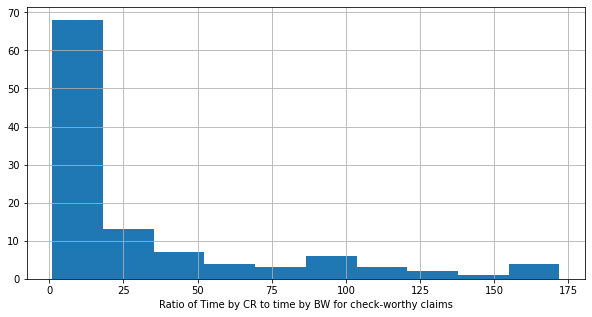

In [86]:
plt.figure(figsize=(10,5))
plt.xlabel('Ratio of Time by CR to time by BW for check-worthy claims')
c[c<200].hist()

In [87]:
c[c<200].mean()

31.990737320560214

In [39]:
np.mean(c[c<50])

12.001860031800144

In [40]:
c[c<200].mean()

16.79517655077404

# T C B

In [89]:
len(set(tcb.tweetId))

43

In [88]:
tcb = merge_corpus[merge_corpus.apply(lambda x: True if x['Tweet_ts']<x['CR_ts'] and x['CR_ts']<x['Note_ts'] else False,axis=1)]

In [90]:
tcb_tweets = list(set(tcb.tweetId))

In [91]:
len(tcb_tweets)

43

In [92]:
for index,row in tcb.drop_duplicates(subset='tweetId').iterrows():
    print(f'Tweet ID: {row.tweetId}')
    print(f'Tweet: {row.full_text}')
    print(f'CR Fact: {row["CR Fact"]}')
    print(f'Note: {row.summary}')
    print(f'Time Difference: {row["Note_ts"]-row["CR_ts"]}')
    print()

Tweet ID: 1359650012125421572
Tweet: .@SenTedCruz says #ImpeachmentTrial is like Shakespeare full of sound and fury signifying nothing. No, that’s Faulkner
CR Fact: ['U.S. Sen. Ted Cruz messed up when he attributed the famous phrase &quot;full of sound and fury / signifying nothing&quot; to William Shakespeare.']
Note: It?s a Shakespearean phrase from Macbeth and it?s easily searchable ~ https://www.poetryfoundation.org/poems/56964/speech-tomorrow-and-tomorrow-and-tomorrow and https://www.sparknotes.com/shakespeare/macbeth/quotes/page/5. It?s perhaps one of the most important quotes from Macbeth.
Time Difference: 0 days 01:29:40.219000

Tweet ID: 1095406768631566338
Tweet: While you’re now complaining about gucci and last year it was Prada and Moncler, did you know that in the late 1800s and in the early 1900s Louis Vuitton sponsored human zoos were black People were looked at as exotic circus like creatures.  
Here is a picture of a Louis Vuitton https://t.co/a28f6iUx1v
CR Fact: ['cla

In [98]:
for index,row in tcb.drop_duplicates(subset='tweetId').iterrows():
    if (row["Note_ts"]-row["CR_ts"]).days>0:
        print(f'Tweet ID: {row.tweetId}')
        print(f'Tweet: {row.full_text}')
        print(f'CR Fact: {row["CR Fact"]}')
        print(f'Note: {row.summary}')
        print(f'Time Difference: {row["Note_ts"]-row["CR_ts"]}')
    print()


Tweet ID: 1095406768631566338
Tweet: While you’re now complaining about gucci and last year it was Prada and Moncler, did you know that in the late 1800s and in the early 1900s Louis Vuitton sponsored human zoos were black People were looked at as exotic circus like creatures.  
Here is a picture of a Louis Vuitton https://t.co/a28f6iUx1v
CR Fact: ['claims that “in the late 1800’s and early 1900 Louis Vuitton sponsored human zoos,” where “Blacks were looked at as exotic circus like creatures.”']
Note: Claim originates from a 2011 article from French blog ?Brand Memory? that recounts Vuitton's showcase of African-themed products at the Exposition Coloniale Internationale in 1931. Sadly, the Exposition also hosted human zoos unrelated to Vuitton's exhibit.    Fact Check Report: https://checkyourfact.com/2021/02/27/fact-check-louis-vuitton-human-zoos-late-1800s-early-1900s/
Time Difference: 2 days 17:36:14.313000



Tweet ID: 1352063773381693443
Tweet: Joe Biden is not my President. Lega

# C T B

In [95]:
ctb = merge_corpus[merge_corpus.apply(lambda x: True if x['CR_ts']<x['Tweet_ts'] and x['Tweet_ts']<x['Note_ts'] else False,axis=1)]

In [97]:
len(set(ctb.tweetId))

2004

In [153]:
all_tweet_topics = pd.read_csv('../data/BW_tweets_all_Topic.csv')

In [154]:
pd.merge(ctb.drop_duplicates(subset='tweetId'),all_tweet_topics,on='tweetId')['Topic'].value_counts()

Outlier         1004
Politics         377
Health           302
Society          122
Nature            60
Economy           41
Country           39
Guns              27
Social Media      22
Technology         3
Sports             3
Food               2
Characters         1
Harry              1
Name: Topic, dtype: int64

In [164]:
for index,row in ctb.drop_duplicates(subset='tweetId').iterrows():
    print(f'Tweet ID: {row.tweetId}')
    print(f'Tweet: {row.full_text}')
    print(f'CR Fact: {row["CR Fact"]}')
    print(f'Note: {row.summary}')
    print(f'Time Difference: {row["Tweet_ts"]-row["CR_ts"]}')
    print()

Tweet ID: 1380985371794796545
Tweet: Trump won the election by a landslide
CR Fact: ['Donald Trump won the 2020 election, by a lot']
Note: According to numerous independent sources, Trump lost the election.    Politifact, 1/6/21: https://www.politifact.com/factchecks/2021/jan/07/donald-trump/trump-clings-fantasy-landslide-victory-egging-supp/    &quot;All 50 states and the District of Columbia have certified their election results, which Congress sought to finalize Jan. 6? There is no evidence that voter fraud affected that outcome.&quot;
Time Difference: 154 days 20:45:44

Tweet ID: 1388990782015692810
Tweet: DONALD TRUMP WON THE 2020 ELECTION BY A LOT!

#DonaldTrump https://t.co/Wgk60OUZg1
CR Fact: ['Donald Trump won the 2020 election, by a lot']
Note: According to numerous independent sources, Trump lost the election.    Politifact, 1/6/21: https://www.politifact.com/factchecks/2021/jan/07/donald-trump/trump-clings-fantasy-landslide-victory-egging-supp/    &quot;All 50 states and th

Tweet ID: 1391785225072435201
Tweet: Trump won the election
CR Fact: ['US President Donald Trump has won the 2020 election.']
Note: According to numerous independent sources, Trump lost the election.    Politifact, 1/6/21: https://www.politifact.com/factchecks/2021/jan/07/donald-trump/trump-clings-fantasy-landslide-victory-egging-supp/    &quot;All 50 states and the District of Columbia have certified their election results, which Congress sought to finalize Jan. 6? There is no evidence that voter fraud affected that outcome.&quot;
Time Difference: 187 days 16:00:30

Tweet ID: 1402487098033197061
Tweet: Trump won 🇱🇷
CR Fact: ['Donald Trump has won the re-election against Joe Biden.']
Note: According to numerous independent sources, Trump lost the election.    Politifact, 1/6/21: https://www.politifact.com/factchecks/2021/jan/07/donald-trump/trump-clings-fantasy-landslide-victory-egging-supp/    &quot;All 50 states and the District of Columbia have certified their election results, whic

Tweet ID: 1403097198871531524
Tweet: What exactly is going on and why are some economists, policymakers and business leaders starting to worry?

Here's a rundown: https://t.co/bcJGyVYumt https://t.co/di1yNi4Tt5
CR Fact: ["\"Trump just gave a $12 billion bailout to farmers hurt by his failed tariffs. This will cost every household in the U.S. $95 \u2026 Trump is borrowing the money from China since his tax cuts blew a trillion dollar hole in the deficit.\""]
Note: This tweet not only misrepresents whether there should worry about the May inflation numbers, but misrepresents the very article it is linking! The tweet implies we should be worried, but prices are up because of the pandemic, expected, and normal. See their own article. https://www.washingtonpost.com/business/2021/06/10/inflation-what-to-know/
Time Difference: 1044 days 21:10:15

Tweet ID: 1416855241518030850
Tweet: Not one of the J6 defendants have been charged with “insurrection.”

Why is the Capitol breach called an insurr

Tweet: If I am reading this correctly, the CDC is admitting that PCR tests cannot differentiate between Covid and the flu and as a result, they will withdraw the authorisation of these tests at the end of 2021.

Am I reading this correctly?

https://t.co/ipchaA6PgB https://t.co/nmiYv0IIal
CR Fact: ["National leader Judith Collins claims that 30 per cent of COVID-19 tests returned a false negative result in the context of New Zealand's managed isolation testing."]
Note: One RT PCR test will be removed from service in December of 2021. Over two hundred others remain approved.  https://www.fda.gov/medical-devices/coronavirus-disease-2019-covid-19-emergency-use-authorizations-medical-devices/in-vitro-diagnostics-euas-molecular-diagnostic-tests-sars-cov-2#individual-molecular
Time Difference: 329 days 22:45:50

Tweet ID: 1356970117838602240
Tweet: The global death rate is the same as 2019, 2018, 2017 🤔

Pandemic?
CR Fact: ["A Facebook post claims the COVID-19 crisis is the latest in a once-


Tweet ID: 1354953657796722693
Tweet: Today, I issued a Presidential Memorandum to protect and expand access to reproductive health care. I am fully committed to protecting women’s health here at home and around the world.
CR Fact: ["\u201cIf we believe that a woman has the constitutional right to control her own body, that right must apply to ALL women, including low-income women. That is why I have consistently voted against the Hyde Amendment and why, as president, I would eliminate it.\u201d"]
Note: Fails to include Biden's attack on the unborn. Contradictory to his religion. 
Time Difference: 598 days 00:45:00

Tweet ID: 1437415611198541828
Tweet: The Daily Beast should be ashamed of themselves. To call Veronica Wolski a “Covid denier” is just downright false. She wanted to be treated with therapeutics, which likely would have saved her life and the hospital denied her, resulting in her death. This is murder. https://t.co/EAt9HfPVwY
CR Fact: ["Seattle journalist tweets that a nurs

Note: Dr. Fauci has repeatedly denied the claim that Hydroxychloroquine works in treating or curing COVID-19.    1. https://www.usatoday.com/story/news/factcheck/2021/06/05/fact-check-fauci-emails-hydroxychloroquine-dont-show-he-lied/7544007002/
Time Difference: 348 days 10:46:13

Tweet ID: 1434411954206957572
Tweet: A] #1 risk factor is obesity.
B] Mom took the shot.
C] “Always wore a mask.”

What do these spell out?

F] FAILING GRADE FOR THE CDC https://t.co/1tpl4HYsQT
CR Fact: ["Doctors prove that masks are \"irrelevant\" to the prevention of COVID-19"]
Note: This woman is a doctor AND lawyer.  She is widely spreading antivax info and has 330000 followers 
Time Difference: 321 days 07:03:54

Tweet ID: 1432682843222773764
Tweet: WARNING: 6.1 earthquake is likely in the San Francisco Bay on 09/01/2021 - https://t.co/5JDzFwMjuy https://t.co/quRIwKv1F2
CR Fact: ["Michibiki satellite of Japan has connection to earthquake felt in Mumbai, Srinagar"]
Note: There is no scientific basis for e

Time Difference: 1669 days 23:18:19

Tweet ID: 1405230753257033741
Tweet: @JoeBiden Biden just now to reporters: You’re the brightest people in the country.

Trump didn’t say that.
CR Fact: ["Donald Trump wrote letter to President Biden stating &quot;Joe, You know I won.&quot;"]
Note: https://www.nytimes.com/interactive/2018/02/14/upshot/trump-compliments-list.html#the-letter-K    Trump may have not used those precise words but ABC News, Chris Cillizza, John King, Chris Matthews, Kristen Powers, Anderson Cooper along with many others in the press, have received compliments from President Trump. 
Time Difference: 146 days 18:28:14

Tweet ID: 1423679978210725898
Tweet: @DrEricDing Much safer then the vaccines, for those not immunocompromised. IMO https://t.co/sCYmNSmhty
CR Fact: ["The \u201ccorona vaccine\u201d is not safe or effective."]
Note: The vaccines are safe and effective according to CDC.   The poster's claims are false, and denagerous.    https://www.cdc.gov/coronavirus/2019-nc

Tweet ID: 1429939376356827136
Tweet: Pfizer CEO’s response for not getting the C-19 vaxxine. https://t.co/8JOZTo0m3V
CR Fact: ["Chief Science Officer for Pfizer Says \"Second Wave\" Faked on False-Positive COVID Tests, \"Pandemic is Over\""]
Note: This video is from December 2020.  He was staring back in December 2020 that he wasn?t going to cut line to get the vaccine ahead of people who needed it first. He got the shot when he was eligible by age in March.  https://apnews.com/article/fact-checking-082947227981
Time Difference: 313 days 22:51:28

Tweet ID: 1367523620193505282
Tweet: @disclosetv Oh my god! INFECTIONS based on a PCR test which the inventor clearly stated that the test does NOT conclude if you are sick or that you will get sick....

Stop this madness! https://t.co/Pk4yEcBqy7
CR Fact: ["PCR tests for Covid-19 have a 100% false positive rate."]
Note: The video shows Kary Mullis discussing PCR testing for HIV, which is a completely distinct virus than SARS-CoV2. PCR tests a

Tweet ID: 1375074519803645954
Tweet: Universal Background Checks on law-abiding gun owners is a non-starter.

We should start discussing universal background checks for the thousands of people pouring across our borders.

Watch how quickly background checks would become “racist” to Democrats.
CR Fact: ["\"Ninety percent of Americans want our background check system strengthened and expanded to cover more gun sales.\""]
Note: Error in logic; no way to determine if an individual is a 'law-abiding citizen' without a background check in the first place.    Factual error; immigrant background checks are current policy:    https://www.uscis.gov/policy-manual/volume-12-part-b-chapter-2    
Time Difference: 1701 days 13:18:07

Tweet ID: 1355365878682927111
Tweet: Gay couple nearly killed by man shouting “fa***ts.” But he wasn’t charged with a hate crime. #lesbian #gay #bisexual #transgender #queer https://t.co/5M9ajs32lJ
CR Fact: ["There has been a 400% increase in hate crime within the LGBT+ 

Tweet ID: 1434518810980241409
Tweet: The American Taliban have seized control of the Supreme Court, and in a few moves it may be checkmate against democracy.
CR Fact: ["Muslim Leader: America Must Understand Sharia Law is Greater Than the Constitution, Therefore Muslims are Above the Law | Daily News Updates"]
Note: Stop using racist, Islamophobic terms to describe white christian fascists. 
Time Difference: 627 days 14:08:31

Tweet ID: 1377614474862006279
Tweet: This is my Covid protection 💪

#MakeAmericaHealthyAgain

It’s time to #FireFauci https://t.co/IgWlTJyBYQ
CR Fact: ["Photographs depict persons who developed staph infections from wearing masks to prevent the spread of COVID-19."]
Note: At least 3 out of every 100 COVID-19 patients have a complication called ARDS. Exercise might be able to reduce the impact on them.    https://newsroom.uvahealth.com/2020/04/15/covid-19-exercise-may-help-prevent-deadly-complication/    But there appears to be no credible evidence that exercise p

Tweet: Richard Spencer approves this tweet. Abortion access for all Black, Hispanic, and WOC is absolutely a goal of the white supremacist at-right. https://t.co/REdWpReft1
CR Fact: ["Says Mike Pence said that \"allowing rape victims to have abortions will lead to women trying to get raped.\""]
Note: The anti-choice movement is deeply tied to white supremacy, NOT the pro-choice movement   https://www.thenation.com/article/politics/anti-abortion-white-supremacy/
Time Difference: 1488 days 12:42:45

Tweet ID: 1384224073706655746
Tweet: With countless killings of Black people by police, the Chauvin trial is reopening fresh wounds: "It physically hurts." https://t.co/ocgcVfZOJL
CR Fact: ["\"The gun epidemic is the leading cause of death of young African-American men, more than the next nine causes put together.\""]
Note: Tweet is severely misleading. The total number of unarmed Africans killed by police in 2020 was 14. Tweet suggests its a number larger than is countable.     https://www.m

Time Difference: 175 days 11:53:57

Tweet ID: 1355236338061160449
Tweet: If you ever questioned how the Democrats felt about the Second Amendment, I think the first few weeks of the 117th Congress confirmed it.
CR Fact: ["Claims that CNN ran a news chyron that reads, \"Democrats Ask, 'Why even have a Second Amendment?'\""]
Note: Tweet conflates the House rules barring firearms from the house floor with an attack on the second amendment. Laws of this type have been on the books for years and tweet willfully uses a misreading of the constitution to support its point here, as detailed in https://washingtonmonthly.com/2021/01/22/no-you-cant-carry-a-gun-on-the-floor-of-the-house/
Time Difference: 431 days 19:28:16

Tweet ID: 1426183680498798596
Tweet: Media: "There's no proof of voter fraud!"

Me: "Did you watch experts at Mike Lindell's Cyber Symposium read the computer code provided by Mesa County Recorder Tina Peters for several hours LINE BY LINE to show you what happened in the 2020 el

Time Difference: 573 days 01:14:55

Tweet ID: 1422613028676177927
Tweet: This Black Women’s Equal Pay Day, we must recognize a hard truth: it takes a Black woman nearly 20 months to earn what a white man makes in one year for the same exact work. It’s unconscionable.
 
My Administration is committed to closing the gender pay gap once and for all. https://t.co/3ijFd5KYIH
CR Fact: ["Black workers face a widening pay gap the more qualifications they earn."]
Note: This alleged &quot;pay gap&quot; Is simply the difference between the average EARNINGS of all workers. It does not account for differences in occupations, positions, education, job tenure or hours worked. When such relevant factors are considered, the &quot;pay gap&quot; essentially vanishes.
Time Difference: 2009 days 17:39:11

Tweet ID: 1377667046826250242
Tweet: 5.5+ earthquake is possible in the San Francisco Bay during the next 24 hours  - https://t.co/Jy5p5TwCyn https://t.co/NwawD46bXH
CR Fact: ["Since fracking recommenced 

Trump WON in a landslide. https://t.co/YVicDHHuTM
CR Fact: ["Donald Trump wrote letter to President Biden stating &quot;Joe, You know I won.&quot;"]
Note: The well-debunked lie in this tweet was tagged by Twitter, but the account remains open. I felt obligated to put a note about that here. This is the exact lie that brought about the need for Birdwatch in the first place.
Time Difference: 25 days 23:59:10

Tweet ID: 1429402304877318146
Tweet: Australia is murdering dogs to stop the spread of COVID-19.
CR Fact: ["People are abandoning pets due to fears of Covid-19 transmission."]
Note: Murder is when one human kills another human.    https://www.merriam-webster.com/dictionary/murder    What Australia did was euthanize the dogs via gunshot for the sake of public health, which may have violated their in-country animal cruelty laws using the crude procedure.    https://news.yahoo.com/rescue-dogs-reportedly-shot-australia-220616477.html
Time Difference: 380 days 11:17:21

Tweet ID: 1415401

Tweet ID: 1401611151344082964
Tweet: I’m not afraid to say it, President Trump won in 2020. 

Vote for pro-Trump Hirsh Singh on June 8th if you stand with President Trump and want to help us make New Jersey Great Again. 

DONATE anything you can and help us win&gt;&gt; https://t.co/RDlWvw3l17 https://t.co/OZe8FcKnt9
CR Fact: ["\"We are coming up on our 40th anniversary of electing a Republican to the United States Senate. 1972 was the last time New Jersey sent a Republican to the United States Senate.\""]
Note: The winner of the 2020 presidential election was Joe Biden. Donald Trump did not win the election. https://www.nytimes.com/interactive/2020/11/03/us/elections/results-president.amp.html%3f0p19G=0232
Time Difference: 1787 days 18:45:13

Tweet ID: 1435365106800594949
Tweet: Are we just supposed to pretend Dominion didn’t accept a $400M payment from the CCP one month before the 2020 election?
CR Fact: ["Photo of Justin Trudeau proves Elections Canada lied when it said it does not u

Tweet ID: 1424496797641175043
Tweet: @lil_lightworker @JoshSandersTV @DanCrenshawTX 1) Vaccinated folks are much less likely to get the disease in the first place (graph from my county's COVID site)
2) The COVID folks clogging ERs and ICUs in TX (which Crenshaw pretends to represent) are virtually all unvaccinated. https://t.co/8b6nlxwg7M
CR Fact: ["Six reasons why one should not take Covid vaccination: Women who are not married should not take the vaccine (chances of not being able to conceive) Children should stay away (chances of infections in the future) People with pneumonia, asthma, or bronchitis or any other respiratory disease (chances of death due to side effects) People who consume alcohol, cigarettes, or tobacco (chances of cancer) People with neural problems (disease can increase) Diabetic patients (even with little side effect, the person can die)"]
Note: Graph posted does not relate to claim number 2. Nothing in post offers support for claim #2. Later post linked below of

Note: This tweet is misleading as the CDC has been recommending masks during the pandemic. https://www.cdc.gov/coronavirus/2019-ncov/your-health/effective-masks.html This person might be making a tongue in cheek joke about early recommendations when COVID was not breaking out in the US, but it?s misleading
Time Difference: 12 days 17:03:07

Tweet ID: 1423472751835242498
Tweet: 5.0+ earthquake is likely in California on 08/06/2021 - Please see risk level in your city.
https://t.co/A6FtAYUBmJ https://t.co/LXHxZrxa6D
CR Fact: ["Mexico has been hit by a devastating earthquake measuring 8.1 on the Richter scale."]
Note: There is no scientific basis for earthquake predictions. There is always a chance for earthquakes in places like California, but specific predictions like these are no better than random. This account posts wildly large predictions nearly every day.    Read more from scientists: https://www.usgs.gov/faqs/can-you-predict-earthquakes
Time Difference: 660 days 02:35:25

Tweet I

Time Difference: 713 days 02:48:43

Tweet ID: 1371887262103920643
Tweet: @MollyBeck @GovEvers The German Red Cross (DRK) halted BioNTech/Pfizer's first vaccine dose. And I'm sure you already know much of Europe suspended AstraZeneca's vaccine. Anyone in this puppet administration in Madison, or its fawning media darlings throughout the state, monitoring adverse reactions?
CR Fact: ["On Nov. 9, 2020, New York Gov. Andrew Cuomo said it was &quot;bad news&quot; that Pfizer had developed what appeared to be a successful COVID-19 vaccine, during U.S. President Donald Trump&#039;s tenure."]
Note: There is no evidence that AZ-Oxford vaccine causes blood clotting:     https://www.ajmc.com/view/what-we-re-reading-az-refutes-blood-clot-links-to-vaccine-europe-case-spikes-1-5b-vaccine-confidence-campaign    All 3 vaccines approved for use in USA have been proven to be safe and effective in phase 3 clinical trials. 
Time Difference: 119 days 18:13:06

Tweet ID: 1436122500123934720
Tweet: How is a 

Time Difference: 470 days 03:05:25

Tweet ID: 1428777191047942150
Tweet: A 3,000 word deep dive into the evidence behind student mask mandates

Many countries around the world - with vax rates, case rates, and mortality above and below the US - do not require masks on students. Why does the US?

My latest for @NYMag 
https://t.co/r2nYIHVPNj
CR Fact: ["Government says healthy people should not wear masks"]
Note: This study is from late 2020. Then one cited in the NY MAG is specifically dealing with kids  
Time Difference: 358 days 17:53:22

Tweet ID: 1398410876785500162
Tweet: Major earthquake is likely in California - Most likely in the Los Angeles - Santa Barbara - Ridgecrest area - late on 05/28 and late on 05/29 - https://t.co/VMyuA1tYdu https://t.co/XxkgyyTaEo
CR Fact: ["NASA warned that Asteroid 52768 (1998 OR2) could hit Earth in April 2020 and cause catastrophic danger."]
Note: There is no scientific basis for earthquake predictions. There is always a chance for earthquakes in C

Time Difference: 366 days 07:13:53

Tweet ID: 1378078237906120717
Tweet: @RepJeffDuncan @MLB Dude they made it a crime to give food and water to people waiting in line to vote. Lines that were 11+ hours long

If you really care about election integrity, investigate that.
CR Fact: ["In March 2021, Georgia lawmakers were considering a bill that would update existing laws that prohibit offering gifts to voters at polls to explicitly include language that would make giving food or water to voters standing in line a misdemeanor crime, no matter the circumstances."]
Note: It is not illegal to hand out water to voters in Georgia. It is illegal for campaign staff to put a sticker on a mug and give it out to people standing in line to influence their vote. People can still get water if needed. https://dailycaller.com/2021/03/31/georgia-voting-bill-absentee-voting-id-requirement-food-water/
Time Difference: 6 days 20:13:50

Tweet ID: 1424777140948643843
Tweet: My decision not to get vaccinated d

Note: The tweet directly contradicts the linked story, subsequently creating a misleading headline intended to mislead the audience that doesn't read the article. 
Time Difference: 335 days 18:30:23

Tweet ID: 1359582152204161027
Tweet: This is dangerous. According to @Heritage's @HvonSpakovsky, "mail-in ballots are the ballots most vulnerable to being altered, stolen, or forged." From missing mail to rejected ballots to technical problems, a mail-in only system cannot ensure that your vote will be counted. https://t.co/abcwaeti86
CR Fact: ["In U.S. elections, mail-in voting systems &quot;substantially&quot; increase the risk of voter fraud compared to in-person voting."]
Note: Mail-in ballots are hand-marked by voters, which the National Conference of State Legislatures considers to be the ?gold standard of election security.? There has been minuscule levels of fraud in states with universal mail-in voting: https://www.washingtonpost.com/politics/minuscule-number-of-potentially-fraudu

Tweet ID: 1431724854047395847
Tweet: WATCH: Joe Biden appears to doze off in the middle of a meeting with Israeli Prime Minister Naftali Bennett https://t.co/2778gJGZI2
CR Fact: ["the video shows Democratic presidential nominee Joe Biden sleeping during a local morning TV interview"]
Note: This was clipped to look like Biden was sleeping, then tweeted as such. Footage before and after show he was merely looking down.      https://twitter.com/RonFilipkowski/status/1431960421305618436?s=20
Time Difference: 362 days 21:06:20

Tweet ID: 1392621166003691520
Tweet: The FBI is hunting peaceful protesters from January 6th because they want to scare everyone else out of telling the truth about the rigged election
CR Fact: ["Claims the FBI confirmed that Antifa breached the U.S. Capitol on Jan. 6, rather than supporters of President Donald Trump."]
Note: The current audit of Maricopa County has not been complete at this time, which would provide better clarity on the election.    Currently, the 

Tweet ID: 1370180003946725379
Tweet: That don't look like the White House!
CR Fact: ["Joe Biden owns the house in this photo."]
Note: Joe Biden's primetime address on March 11, 2021 concerning the ongoing COVID-19 pandemic was given from the East Room of the White House as reported (and photographed) by numerous news organizations https://www.nytimes.com/live/2021/03/11/us/joe-biden-news/biden-directs-states-to-make-all-adult-americans-eligible-for-vaccine-by-may-1
Time Difference: 145 days 01:09:04

Tweet ID: 1425475236003291142
Tweet: Texas has millions in COVID-19 rent relief. Here’s how Dallas renters and landlords can get it https://t.co/4Yyyl84vHK
CR Fact: ["FEMA is paying for hotel rooms in Texas"]
Note: Senator Cornyn of Texas voted against the bill that provides the COVID-19 rent relief he is touting in this tweet.    https://www.latimes.com/politics/story/2021-03-06/senate-passes-covid-relief-bill
Time Difference: 174 days 15:12:34

Tweet ID: 1360276391158308864
Tweet: Despit

That’s it, that’s the tweet. https://t.co/LOPfgnZn7V
CR Fact: ["A widely circulated Facebook post claims that there is no COVID-19 pandemic."]
Note: There have been almost 200M cases, and over 4M deaths due to covid. This tweet is factually incorrect and completely trivializes the illnesses and deaths of these people.    https://covid19.who.int/
Time Difference: 396 days 15:17:01

Tweet ID: 1354861746897346560
Tweet: From Robinhood employee posted to Reddit https://t.co/dGgQFZogiL
CR Fact: ["Says Warren Buffett has publicly said his secretary \"should not be paying a higher tax rate\" than him."]
Note: The Reddit post in the screenshot does not provide evidence that the anonymous poster is an employee at Robinhood, or that any of the info said is true. This is an unconfirmed claim.
Time Difference: 1563 days 18:39:47

Tweet ID: 1358562954015174659
Tweet: A lot of people seem to be just finding out that Florida’s COVID strategy largely has been fuck it. Florida has been wide open for mo